Uses RL util to visualise the nmf of activations and attributions. It saves the results of the attribution visualization to your Google drive.

#Install and imports

In [1]:
%tensorflow_version 1.x

!pip uninstall lucid -y
!pip install git+https://github.com/tensorflow/lucid.git#egg=lucid

!git clone https://github.com/arunraja-hub/Preference_Extraction.git

!pip install tf-agents==0.3.0

!pip uninstall tensorflow-probability -y
!pip install tensorflow-probability==0.7.0

!npm install -g svelte-cli@2.2.0

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

TensorFlow 1.x selected.
Uninstalling lucid-0.3.8:
  Successfully uninstalled lucid-0.3.8
  Cloning https://github.com/tensorflow/lucid.git to /tmp/pip-install-p9iogsu_/lucid
  Running command git clone -q https://github.com/tensorflow/lucid.git /tmp/pip-install-p9iogsu_/lucid
  Created wheel for lucid: filename=lucid-0.3.9-cp36-none-any.whl size=158758 sha256=faf754ba14e18caddf7907a5b5270bc72dc6100b7ce52cb325a481d27bde56d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-fuzd44l2/wheels/64/c2/51/7238e75f457453774587708b21cd3cf32f9a86456648688634
Successfully built lucid
Cloning into 'Preference_Extraction'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 747 (delta 89), reused 39 (delta 32), pack-reused 591
Receiving objects: 100% (747/747), 33.77 MiB | 10.80 MiB/s, done.
Resolving deltas: 100% (127/127), done.
     |████████████████████████████████| 839kB 2.7MB/s 
     |███████

In [2]:
import numpy as np

from tf_agents.trajectories.time_step import TimeStep
from tf_agents.specs.tensor_spec import TensorSpec
from tf_agents.specs.tensor_spec import TensorSpec
from tf_agents.specs.tensor_spec import BoundedTensorSpec
from tf_agents.networks import q_network

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.misc.io.showing as showing
from lucid.misc.channel_reducer import ChannelReducer
import lucid.optvis.param as param
import lucid.optvis.objectives as objectives
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.reading import read
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte
from lucid.misc.gradient_override import gradient_override_map
from lucid.scratch.rl_util import *
import matplotlib.pyplot as plt


import concurrent.futures
import itertools
import os
import pickle
import random
import sys
import time
import joblib

import numpy as np
import io
import collections

import urllib.request
from urllib.error import HTTPError

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


# Read data

In [0]:
class Trajectory(
    collections.namedtuple('Trajectory', [
        'step_type',
        'observation',
        'action',
        'policy_info',
        'next_step_type',
        'reward',
        'discount',
    ])):
  """Stores the observation the agent saw and the action it took.
      The rest of the attributes aren't used in this code."""
  __slots__ = ()

class ListWrapper(object):
  def __init__(self, list_to_wrap):
    self._list = list_to_wrap

  def as_list(self):
    return self._list

class RenameUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
      if name == "Trajectory":
        return Trajectory
      if name == "ListWrapper":
        return ListWrapper

      return super(RenameUnpickler, self).find_class(module, name)

def rename_load(s):
    """Helper function analogous to pickle.loads()."""
    return RenameUnpickler(s, encoding='latin1').load()

In [0]:
# Modified read trajectories functions to read files from local storage

def load_file(full_path):
    try:
        with open(full_path, 'rb') as f:
            data = rename_load(f)
            return data
    except:
        return None
    
def all_load_data(base_path):
    
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    
    futures = []
    for i in range(5000):
        full_path = os.path.join(base_path, "ts"+str(i)+".pickle")
        future = executor.submit(load_file, full_path)
        futures.append(future)
    
    raw_data = []
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result:
            raw_data.append(result)
    
    return raw_data


all_raw_data = all_load_data("Preference_Extraction/data/simple_env_1/")

In [0]:
all_observations = []
ys = []
satisfactions = []
dense_activations = []

for data in all_raw_data:
  for i in range(data.observation.shape[0]):
    obs = np.copy(data.observation[i])
    y = data.policy_info['satisfaction'].as_list()[i] > -6
    dense_act = np.copy(data.policy_info["activations"][i])

    all_observations.append(np.array(obs))
    ys.append(np.array(y))
    satisfactions.append(np.array(data.policy_info['satisfaction'].as_list()[i]))
    dense_activations.append(np.array(dense_act))

ys = np.array(ys)
satisfactions = np.array(satisfactions)
dense_activations = np.array(dense_activations)
all_observations = np.array(all_observations)

In [6]:
print(ys.shape)

(23750,)


# Load model and get nmf and acts

In [7]:
model = models.Model.load("Preference_Extraction/lucid_save_model.pb")
model.load_graphdef()

In [0]:
num_obs = 4000
some_observations = all_observations[0:num_obs]
some_dense_activations = dense_activations[0:num_obs]
some_satisfactions = satisfactions[0:num_obs]
some_ys = ys[0:num_obs]

In [0]:
output_layer_name = "QNetwork/dense/BiasAdd"
# hidden_layer_name = "QNetwork/EncodingNetwork/EncodingNetwork/conv2d_1/Relu"
hidden_layer_name = "QNetwork/EncodingNetwork/EncodingNetwork/conv2d/Relu"
num_features = 6

In [10]:
nmf_activations =  LayerNMF(model, hidden_layer_name, some_observations, features=num_features)
nmf_attributions = LayerNMF(model, hidden_layer_name, some_observations, features=num_features, attr_layer_name=output_layer_name)

In [0]:
with tf.Graph().as_default(), tf.Session():
  t_input = t_input = tf.placeholder_with_default(some_observations, some_observations.shape, name="lucid_placeholder")
  T = render.import_model(model, t_input, t_input)
  conv_acts = T(hidden_layer_name).eval()

# Define helper functions

In [0]:
def reduce_and_norm(to_reduce, nmf):
  reduced = nmf.transform(np.abs(to_reduce))

  nmf_norms = nmf.channel_dirs.sum(-1)
  reduced *= nmf_norms[None, None, None]

  normalize_by = np.median(reduced.max(axis=(-3, -2, -1)))
  print("normalize_by", normalize_by)
  if normalize_by != 0:
    reduced /= normalize_by # normalize to make the visualization balanced, may need tweaking
  reduced = np.abs(reduced)

  return reduced

In [0]:
def show_with_obs(obs, reduced, num_to_show):
  start = 0 #random.randint(0, obs.shape[0]-num_to_show)

  print("Time left in episode")
  show(zoom_to(obs[start:start+num_to_show, :, :, 3:4], 200))
  print("Color channels (vertical stripes are 'apples'")
  show(zoom_to(obs[start:start+num_to_show, :, :, :3], 200))
  print("Visualization")
  show(zoom_to(reduced[start:start+num_to_show], 200))

# NMF trained on **attributions**. Used to optimize **activations**.
One of the channels usually corasponds to apples.

normalize_by 10.758571775864302
Time left in episode



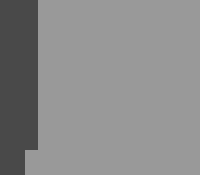
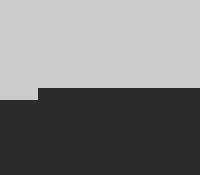
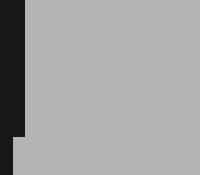
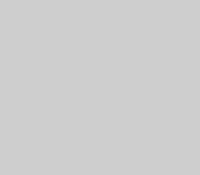
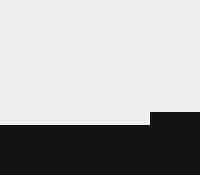
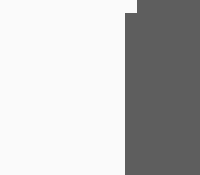
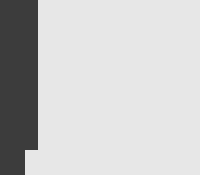
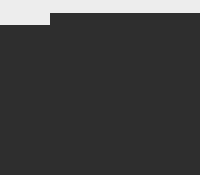
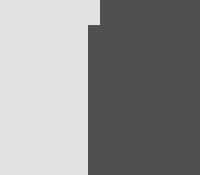
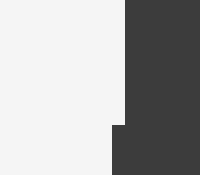
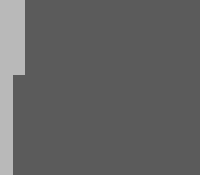
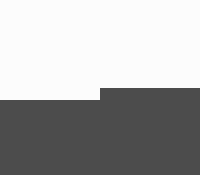
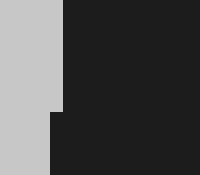
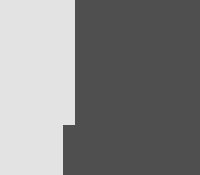
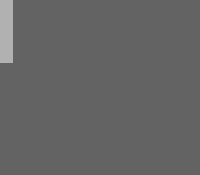
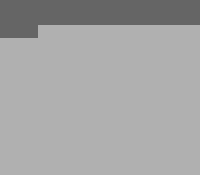
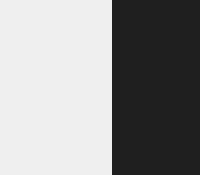
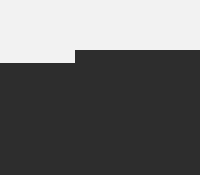
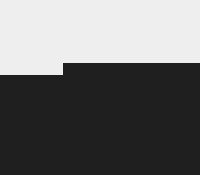
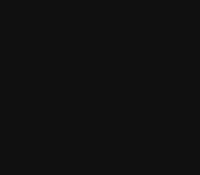
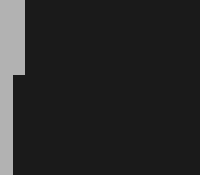
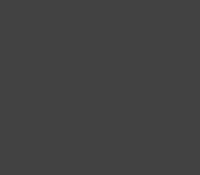
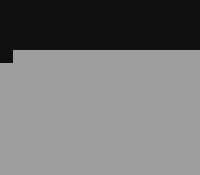
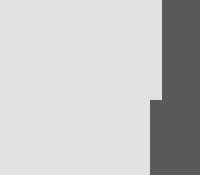
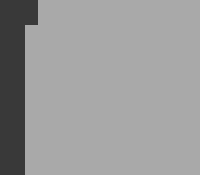
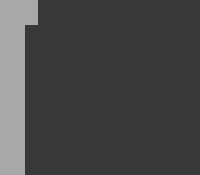
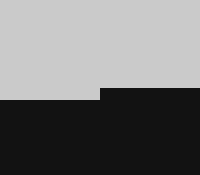
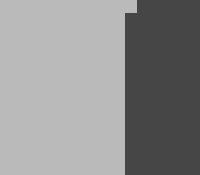
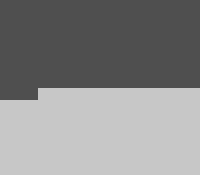
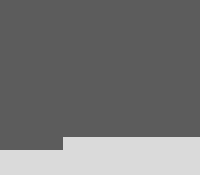
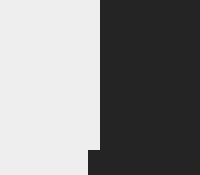
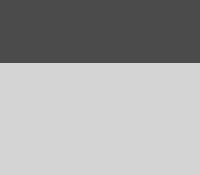
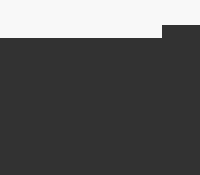
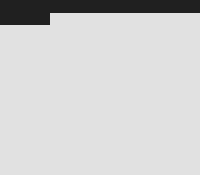
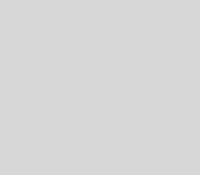
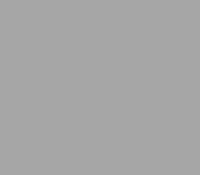
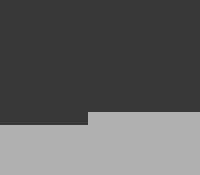
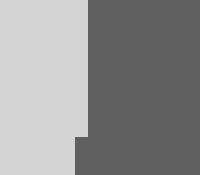
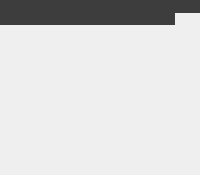
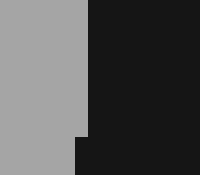
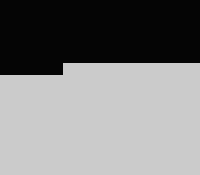
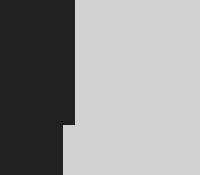
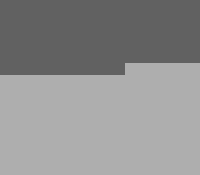
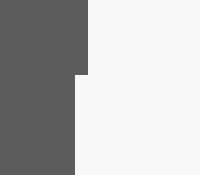
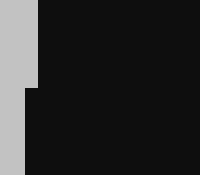
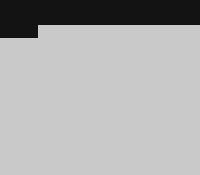
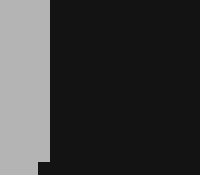
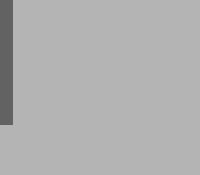
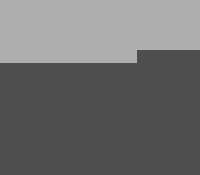
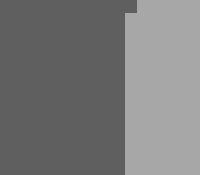

Color channels (vertical stripes are 'apples'



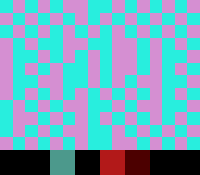
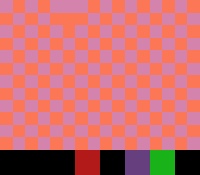
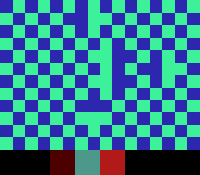
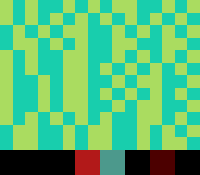
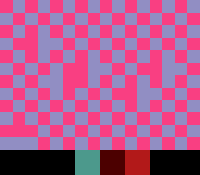
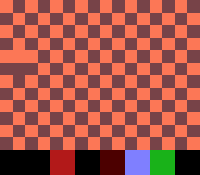
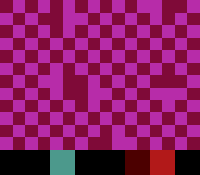
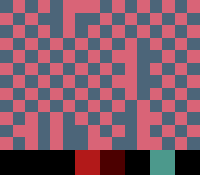
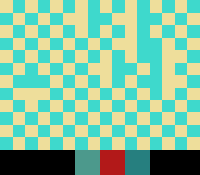
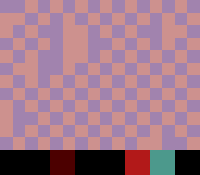
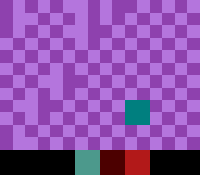
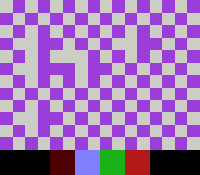
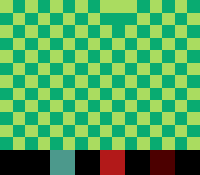
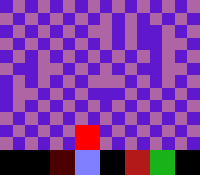
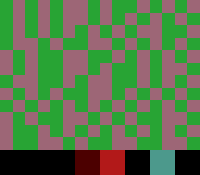
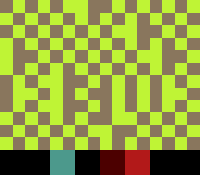
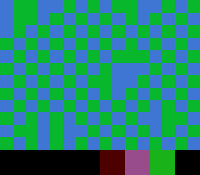
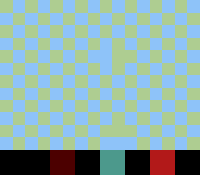
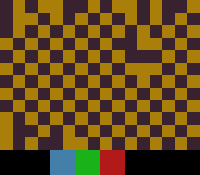
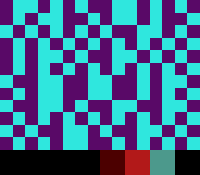
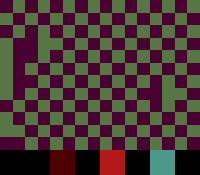
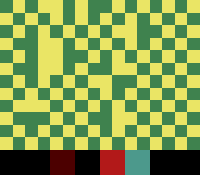
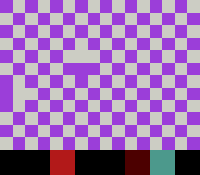
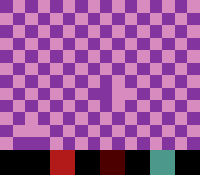
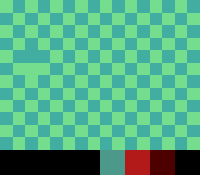
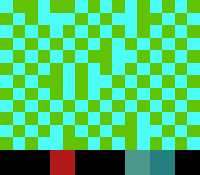
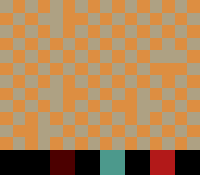
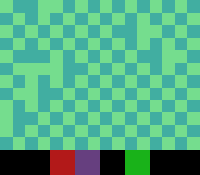
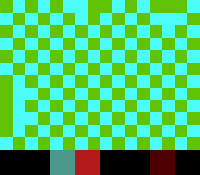
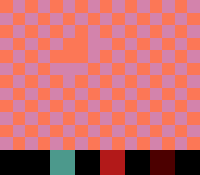
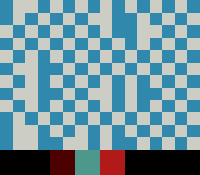
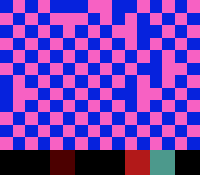
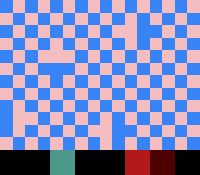
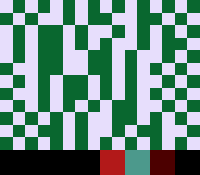
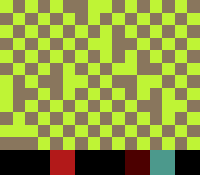
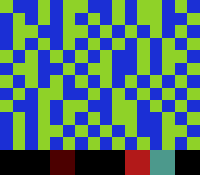
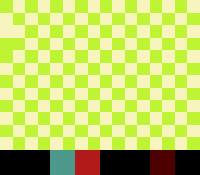
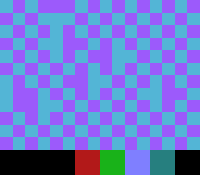
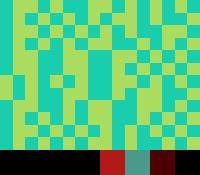
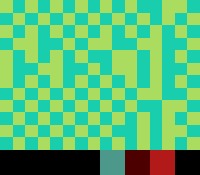
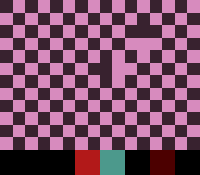
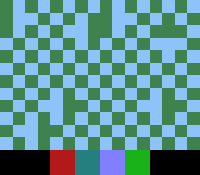
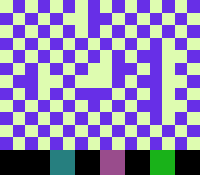
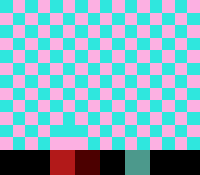
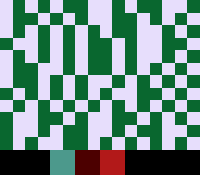
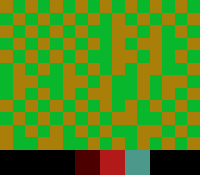
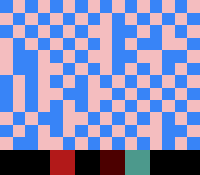
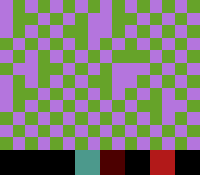
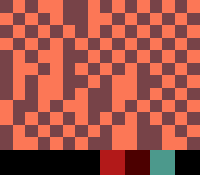
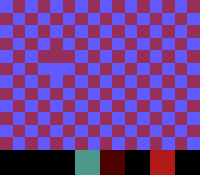

Visualization



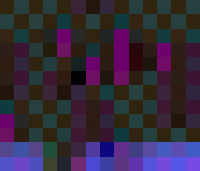
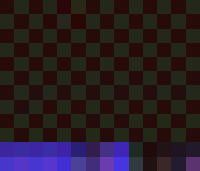
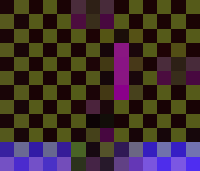
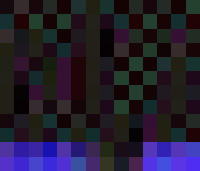
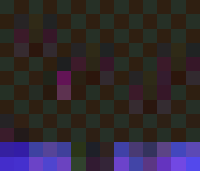
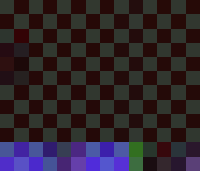
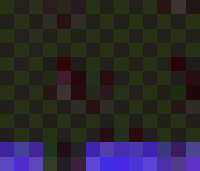
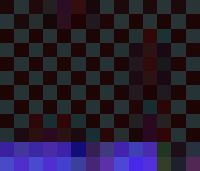
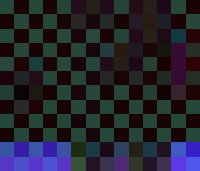
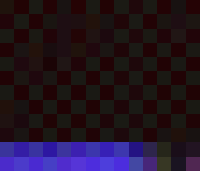
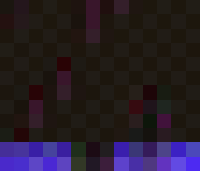
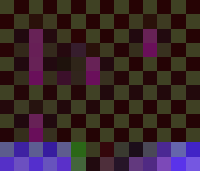
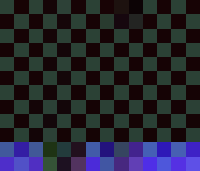
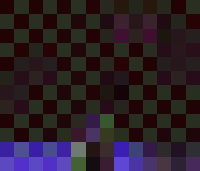
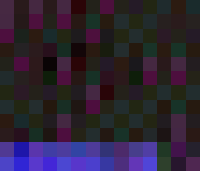
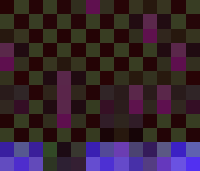
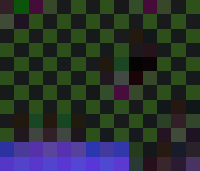
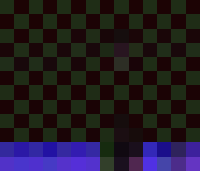
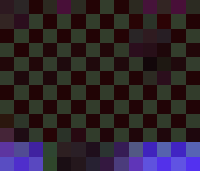
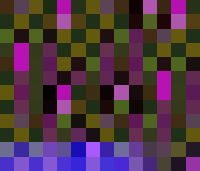
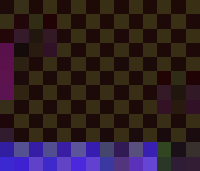
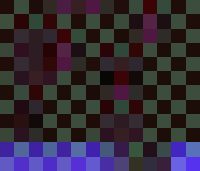
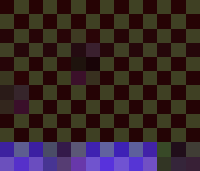
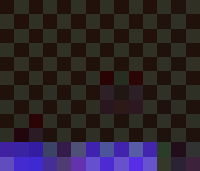
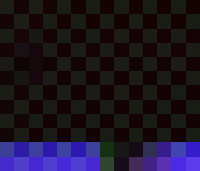
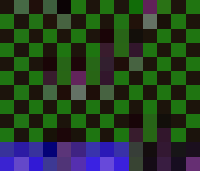
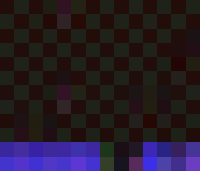
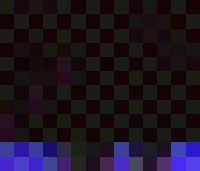
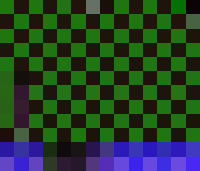
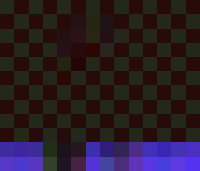
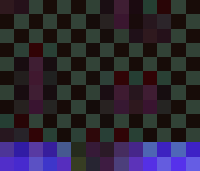
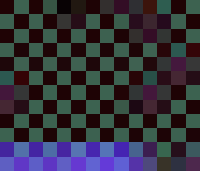
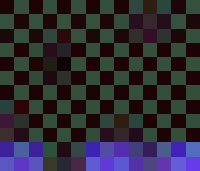
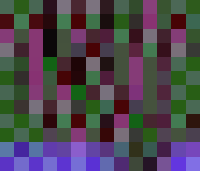
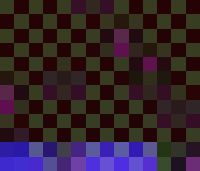
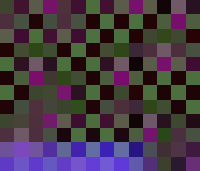
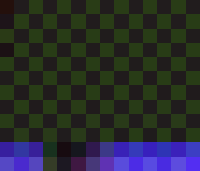
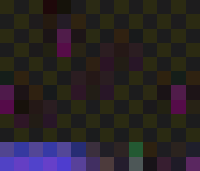
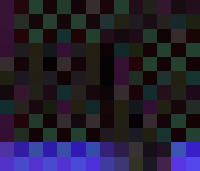
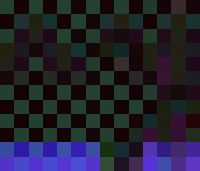
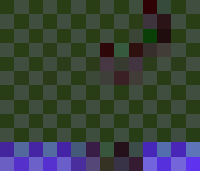
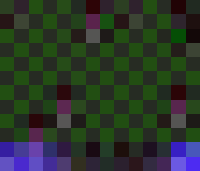
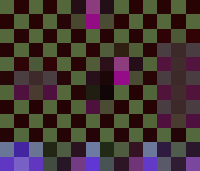
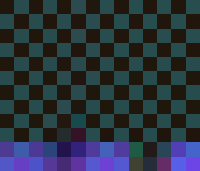
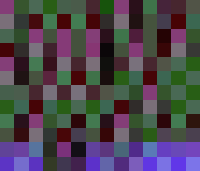
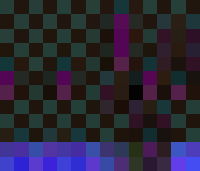
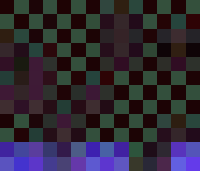
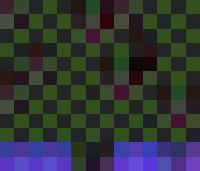
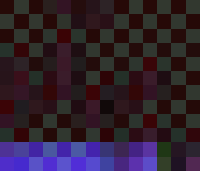
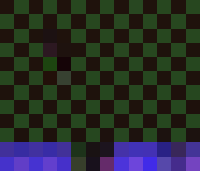

In [14]:
reduced_train_attri_opt_act = reduce_and_norm(conv_acts, nmf_attributions)
show_with_obs(some_observations, reduced_train_attri_opt_act, 50)

# NMF trained on **activations**. Used to optimize **activations**.
One of the channels usually corasponds to apples.

normalize_by 21.390676837181147
Time left in episode



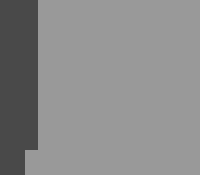
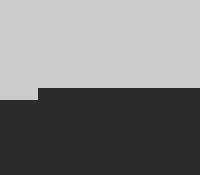
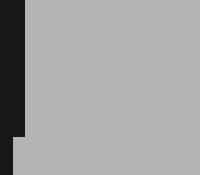
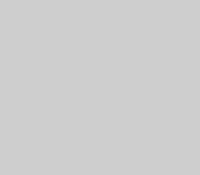
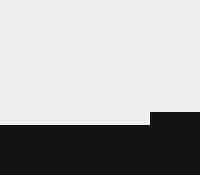
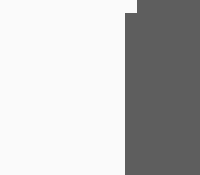
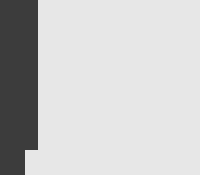
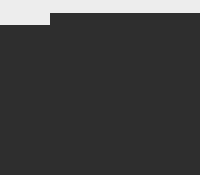
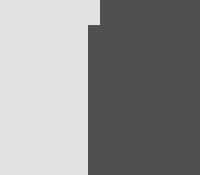
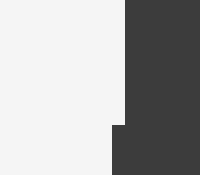
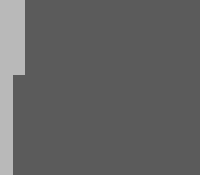
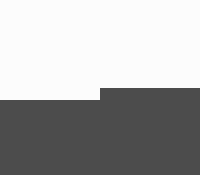
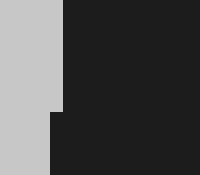
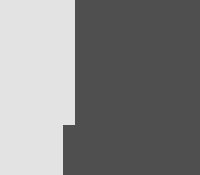
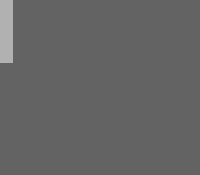
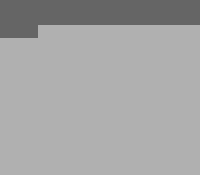
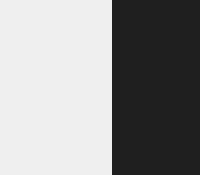
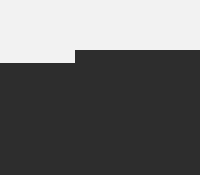
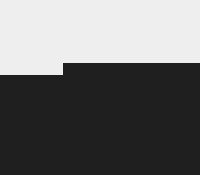
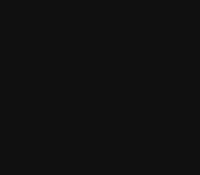
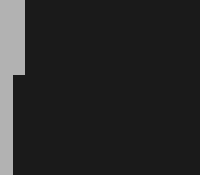
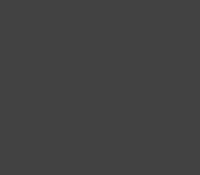
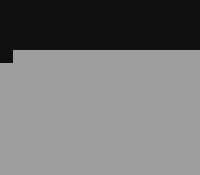
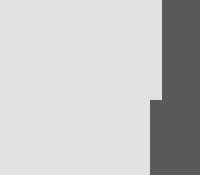
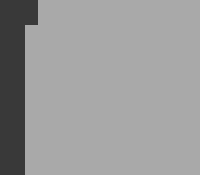
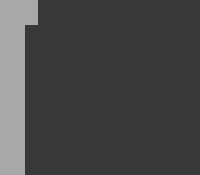
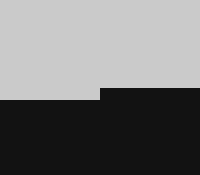
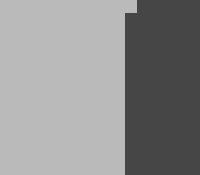
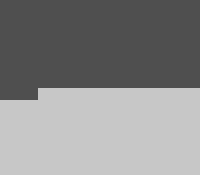
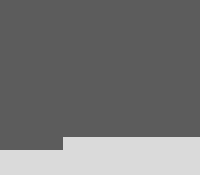
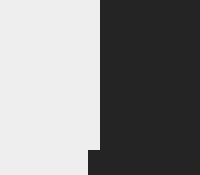
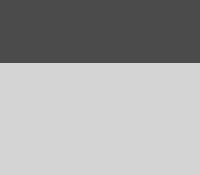
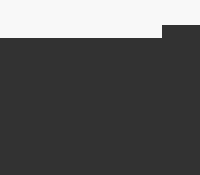
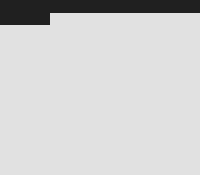
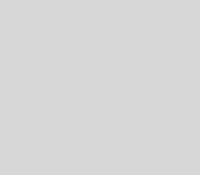
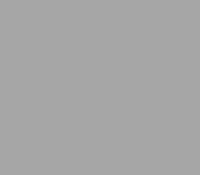
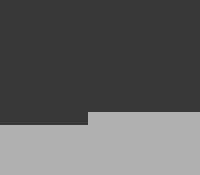
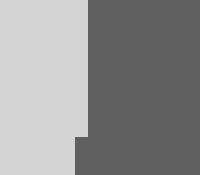
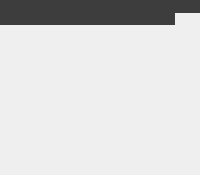
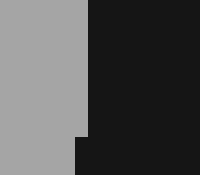
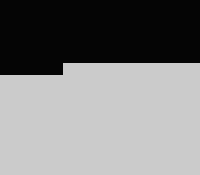
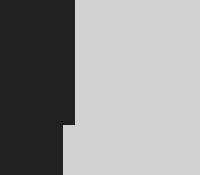
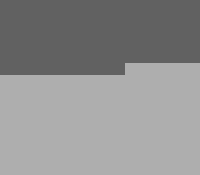
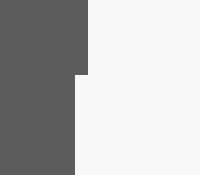
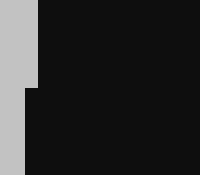
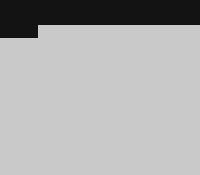
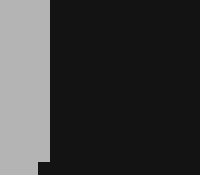
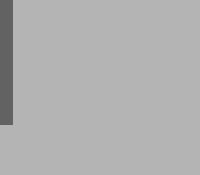
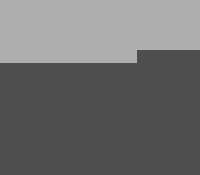
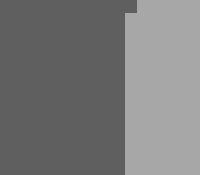

Color channels (vertical stripes are 'apples'



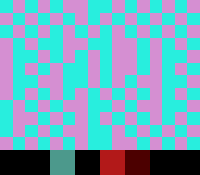
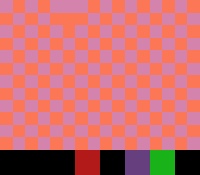
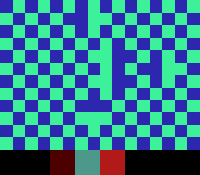
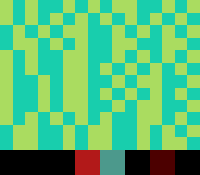
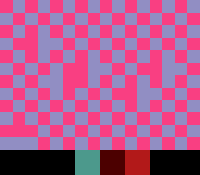
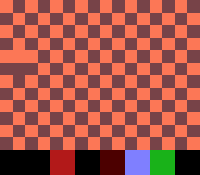
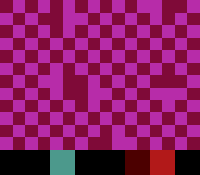
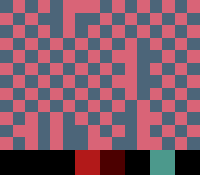
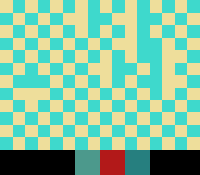
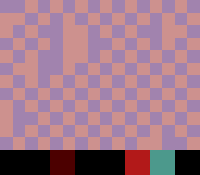
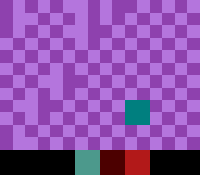
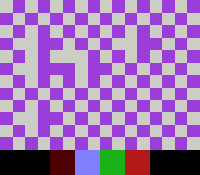
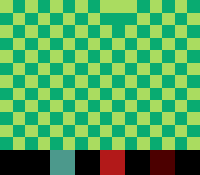
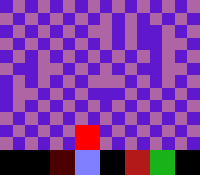
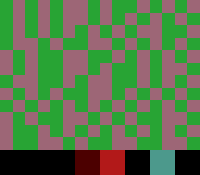
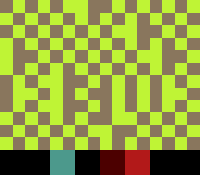
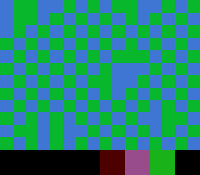
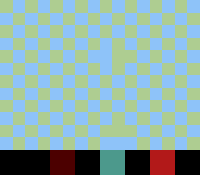
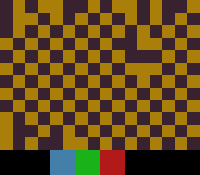
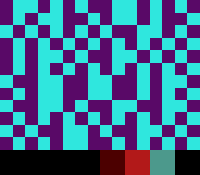
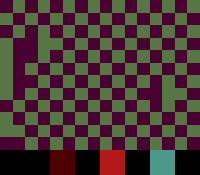
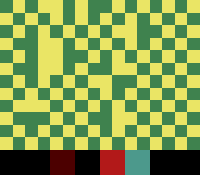
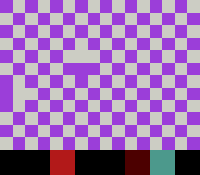
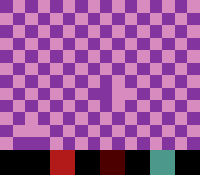
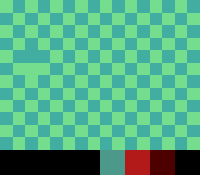
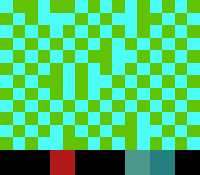
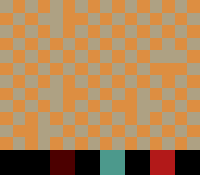
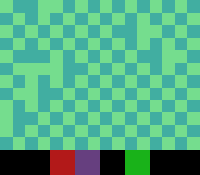
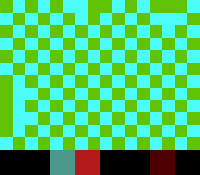
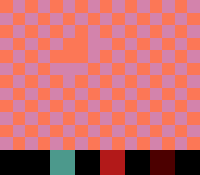
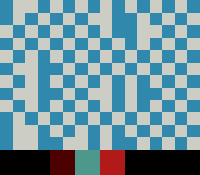
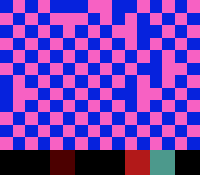
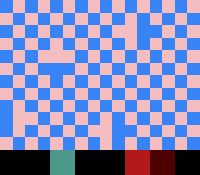
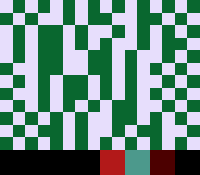
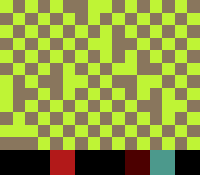
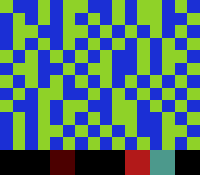
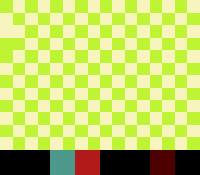
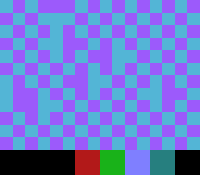
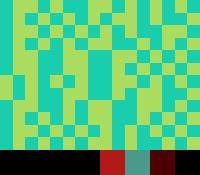
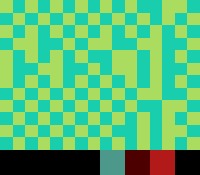
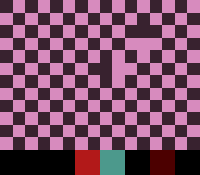
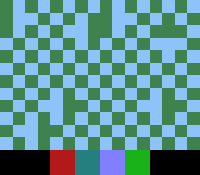
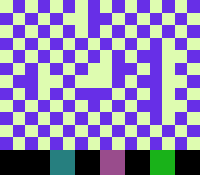
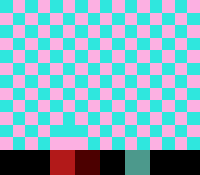
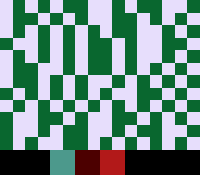
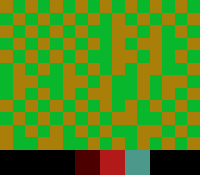
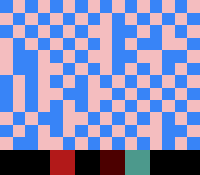
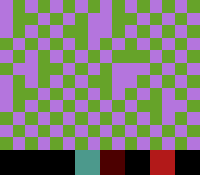
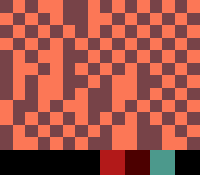
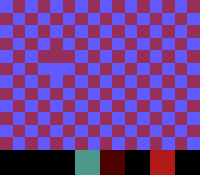

Visualization



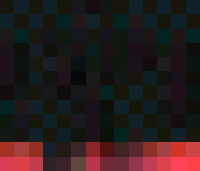
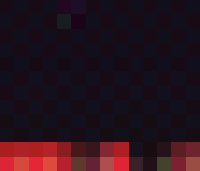
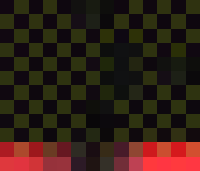
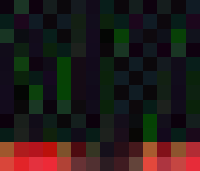
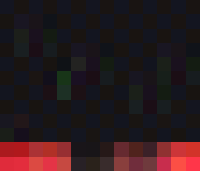
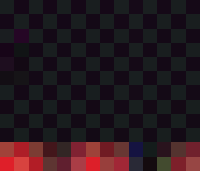
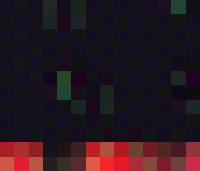
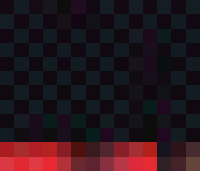
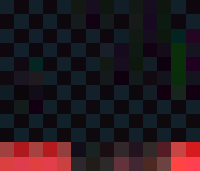
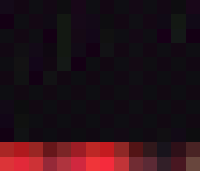
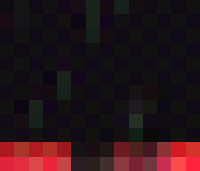
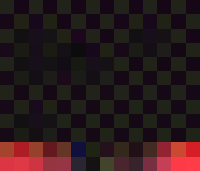
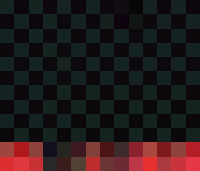
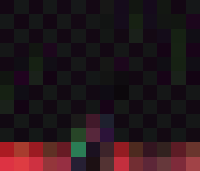
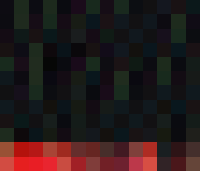
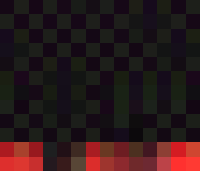
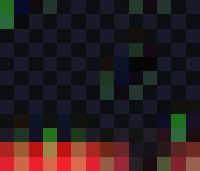
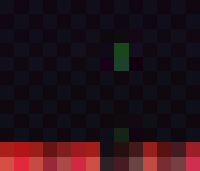
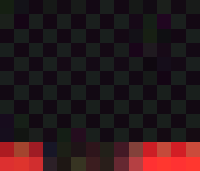
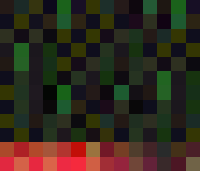
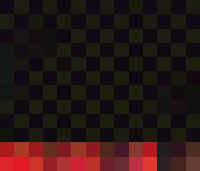
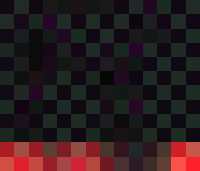
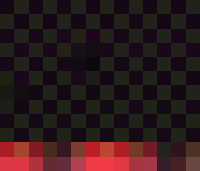
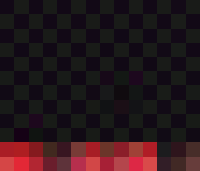
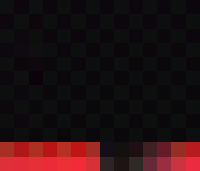
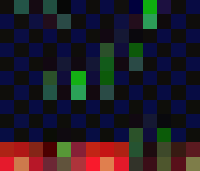
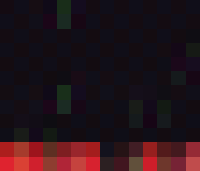
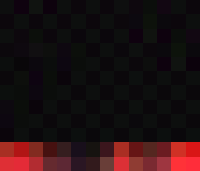
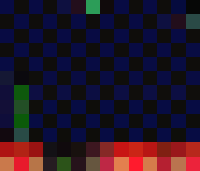
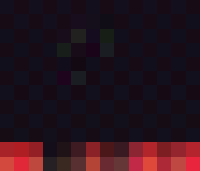
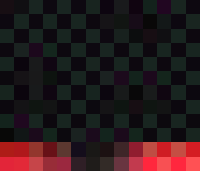
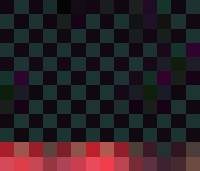
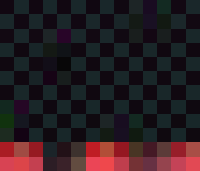
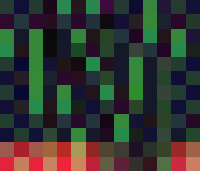
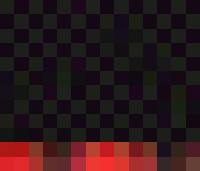
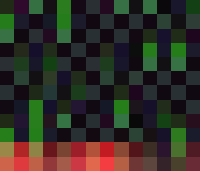
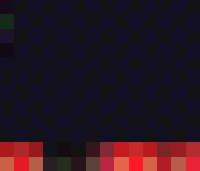
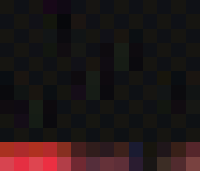
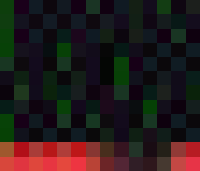
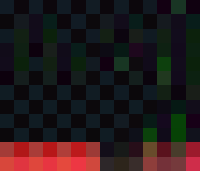
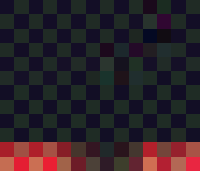
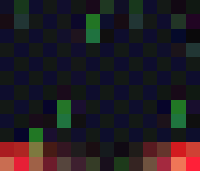
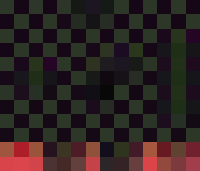
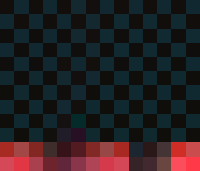
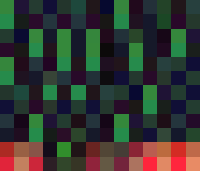
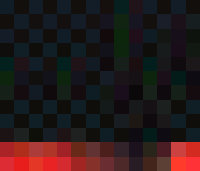
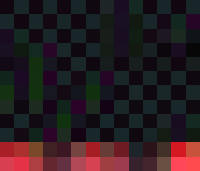
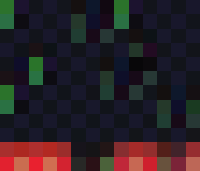
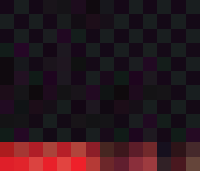
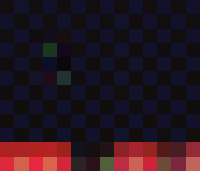

In [15]:
reduced_train_act_opt_act = reduce_and_norm(conv_acts, nmf_activations)
show_with_obs(some_observations, reduced_train_act_opt_act, 50)

# Save results to your Google drive

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [17]:
file_path = '/content/drive/My Drive/pref_extract_files/'
try:
  os.makedirs(file_path)
except FileExistsError:
  pass

joblib.dump(some_ys, os.path.join(file_path, 'ys.pkl'))
joblib.dump(some_dense_activations, os.path.join(file_path, 'dense_activations.pkl'))
joblib.dump(conv_acts, os.path.join(file_path, 'conv_activations.pkl'))
joblib.dump(some_satisfactions, os.path.join(file_path, 'satisfactions.pkl'))
joblib.dump(some_observations, os.path.join(file_path, 'observations.pkl'))

joblib.dump(reduced_train_attri_opt_act, os.path.join(file_path, 'reduced_train_attri_opt_act.pkl'))
joblib.dump(reduced_train_act_opt_act, os.path.join(file_path, 'reduced_train_act_opt_act.pkl'))

['/content/drive/My Drive/pref_extract_files/reduced_train_act_opt_act.pkl']

# NMF on attributions with ```score_fn = tf.reduce_sum```
The visualizations are confusing to me. They don't seem to relate to the input image.

normalize_by 67.79198874489475
Time left in episode



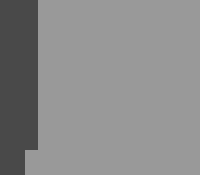
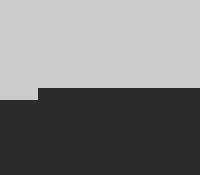
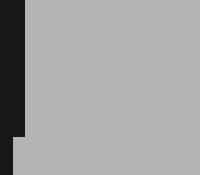
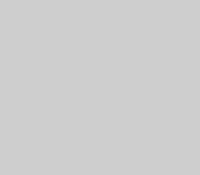
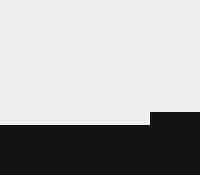
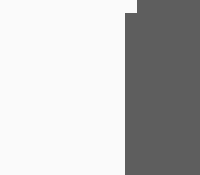
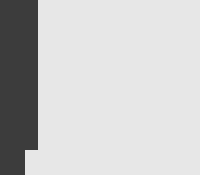
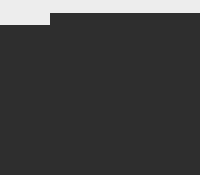
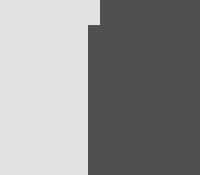
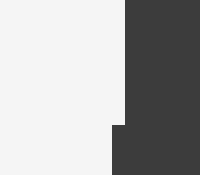

Color channels (vertical stripes are 'apples'



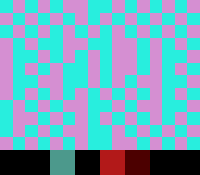
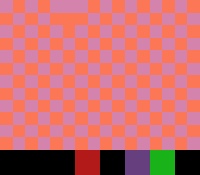
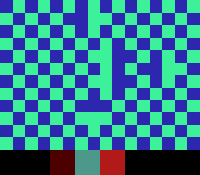
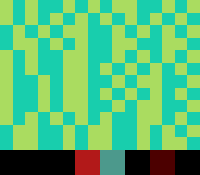
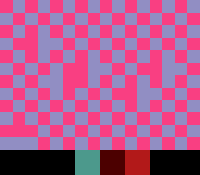
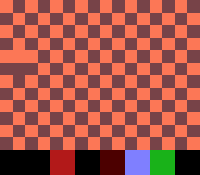
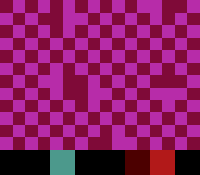
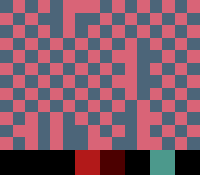
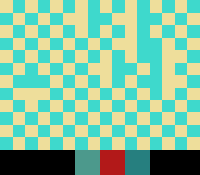
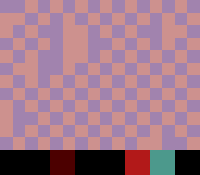

Visualization



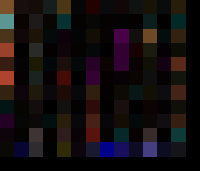
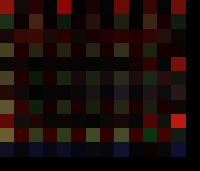
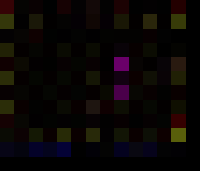
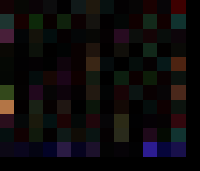
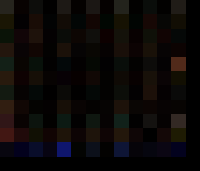
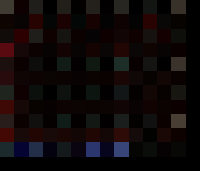
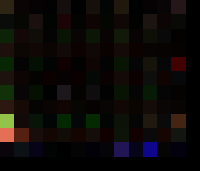
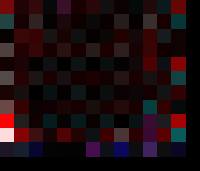
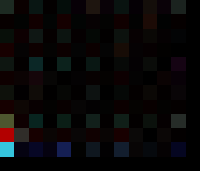
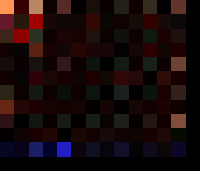

In [18]:
score_fn = tf.reduce_sum
attr = get_attr(model, output_layer_name, hidden_layer_name, some_observations, integrate_steps=10, score_fn=score_fn)
reduced = reduce_and_norm(attr, nmf_attributions)
show_with_obs(some_observations, reduced, 10)

# NMF on attributions with ```score_fn = tf.reduce_max```
Most of the visualzations are 0. Maybe I'm doing something wrong?

normalize_by 0.0
Time left in episode



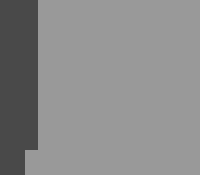
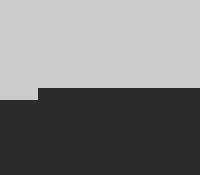
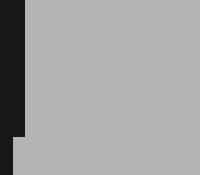
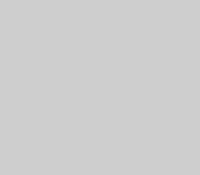
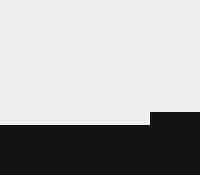
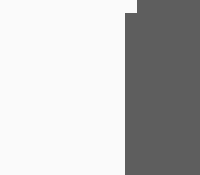
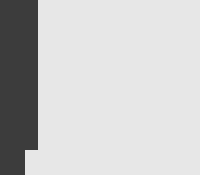
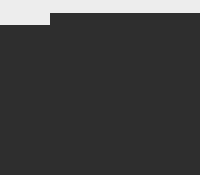
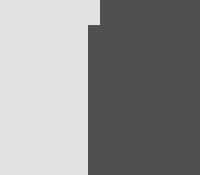
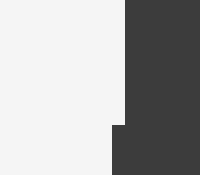

Color channels (vertical stripes are 'apples'



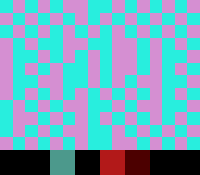
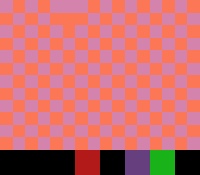
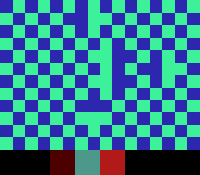
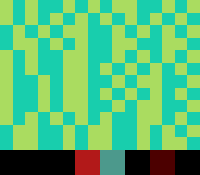
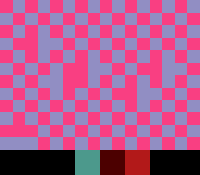
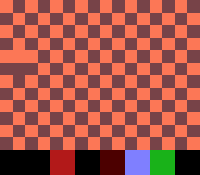
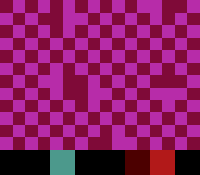
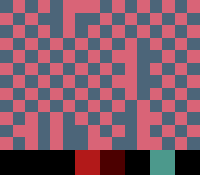
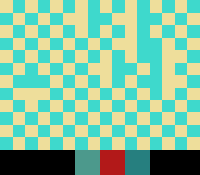
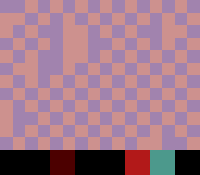

Visualization



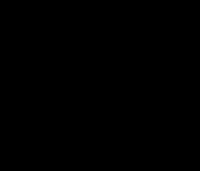
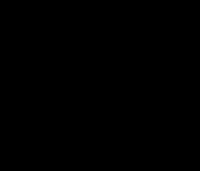
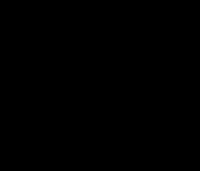
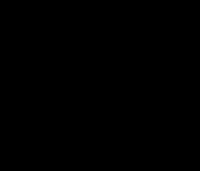
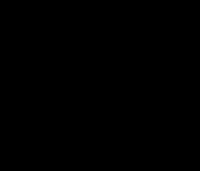
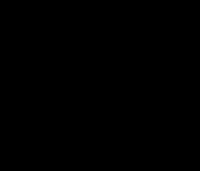
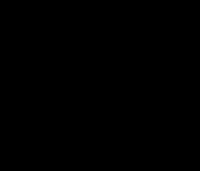
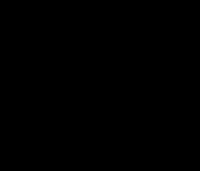
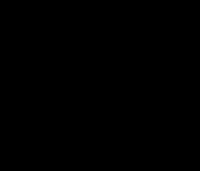
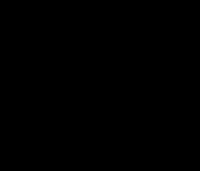

In [19]:
score_fn = tf.reduce_max
attr = get_attr(model, output_layer_name, hidden_layer_name, some_observations, integrate_steps=10, score_fn=score_fn)
reduced = reduce_and_norm(attr, nmf_attributions)
show_with_obs(some_observations, reduced, 10)

number non 0: 4
normalize_by 0.0
Time left in episode



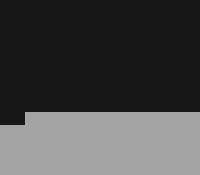
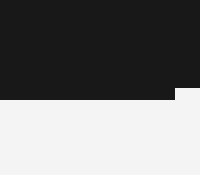
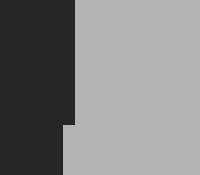
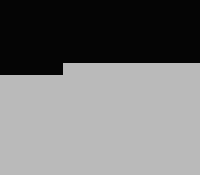

Color channels (vertical stripes are 'apples'



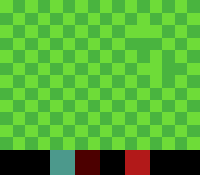
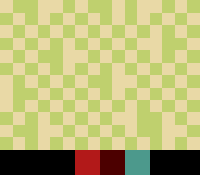
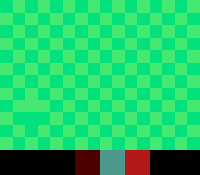
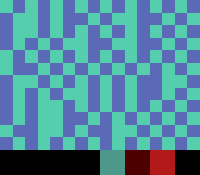

Visualization



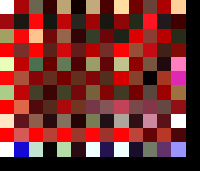
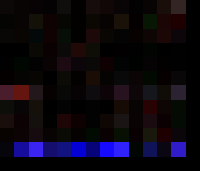
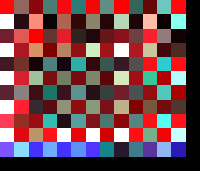
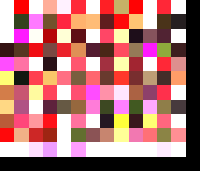

In [20]:
score_fn = tf.reduce_max
attr = get_attr(model, output_layer_name, hidden_layer_name, some_observations, integrate_steps=10, score_fn=score_fn)

non_0 = np.not_equal(np.mean(np.abs(attr), axis=(1,2,3)), 0.0)
num_non_0 = np.sum(non_0)
print("number non 0:", num_non_0)
non_0_attr = attr[non_0]

reduced = reduce_and_norm(attr, nmf_attributions)
show_with_obs(some_observations[non_0], reduced[non_0], num_non_0)